In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt 
import re
import matplotlib.patches as patches
from matplotlib.path import Path

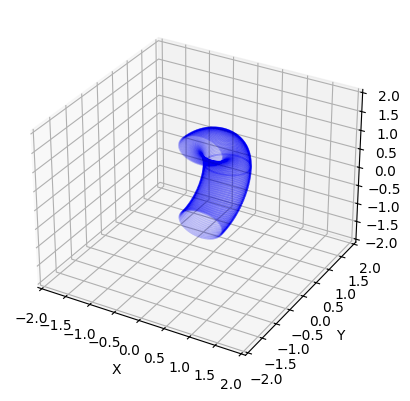

In [12]:
path = '../velocity_results/alpha04_2D_'


geometry_2D = np.load(path + 'geometry.npy')

x_core_2d, y_core_2d, _, x_ring_2d, y_ring_2d = geometry_2D.T

theta = np.linspace(0, 2*np.pi, 181)
Theta = np.repeat(theta[np.newaxis, :], x_core_2d.size, axis=0)
Z_core_2d = y_core_2d[:, np.newaxis] * np.sin(Theta)
Y_core_2d = y_core_2d[:, np.newaxis] * np.cos(Theta)
X_core_2d = np.repeat(x_core_2d[:, np.newaxis], len(theta), axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
k_theta = len(theta) // 4
cross_section_x = np.concatenate((X_core_2d[:, -k_theta:], X_core_2d[:, :k_theta]))
cross_section_y = np.concatenate((Y_core_2d[:, -k_theta:], Y_core_2d[:, :k_theta]))
cross_section_z = np.concatenate((Z_core_2d[:, -k_theta:], Z_core_2d[:, :k_theta]))

ax.scatter(cross_section_x, cross_section_y, cross_section_z, c='b', s=0.1, alpha=0.05)
# ax.scatter(X_core_2d, Y_core_2d, Z_core_2d, c='r', s=1)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

def find_inside_points(data):
    x_2d = data[:, 0]
    # y_2d = sqrt(y_3d^2 + z_3d^2)
    y_2d = np.sqrt(data[:, 1]**2 + data[:, 2]**2)
    upper_core = Path(np.vstack([x_core_2d, y_core_2d]).T).contains_points(np.vstack([x_2d, y_2d]).T)
    return data[upper_core], data[~upper_core]



Load data in the `.pkl` and `.npy` files

In [4]:
directory = '../influx_random_sims_3D/N_realisation_6_bounce/'

with open(os.path.join(directory, 'collision_series.pkl'), 'rb') as f:
    collision_series = pickle.load(f) 

# with open(os.path.join(directory, 'masters_slaves_series.pkl'), 'rb') as f:
#     masters_slaves_series = pickle.load(f)


files = sorted([file for file in os.listdir(directory) if file.endswith('.npy')], key=lambda x: int(re.search(r'\d+', x).group()))

# # load geometry file
# with open(os.path.join('velocity_results', 'alpha04_2D_geometry.npy'), 'rb') as f:
#     geometry = pickle.load(f)

# directory_b = '../influx_random_sims_contInjection/N_realisation_54_bounce/'
# with open(os.path.join(directory_b, 'collision_series.pkl'), 'rb') as f:
#     collision_series_b = pickle.load(f)
# with open(os.path.join(directory_b, 'masters_slaves_series.pkl'), 'rb') as f:
#     masters_slaves_series_b = pickle.load(f)

# files_b = sorted([file for file in os.listdir(directory_b) if file.endswith('.npy')], key=lambda x: int(re.search(r'\d+', x).group()))

In [16]:
# for n, file in enumerate(files):
#     data = np.load(os.path.join(directory, file))

#     fig, ax = plt.subplots()
#     this_ax = ax
#     marker_size = (data[:, -1] * 3/8 +0.625)
#     this_ax.scatter(data[:, 1], data[:, 2], s=marker_size**0.5, marker='o', c='k', linewidths=0)
#     circle = patches.Circle((0, 0), radius=1, fill=False, color='r')
#     this_ax.add_patch(circle)
#     this_ax.set_xlim([-2, 2])
#     this_ax.set_ylim([-2, 2])
#     this_ax.set_aspect('equal')
#     this_ax.set_title('volume-weighted-average Coalescence at t = {:.3f}'.format(n*dt))
#     plt.savefig(os.path.join(directory, 'frame_{}.png'.format(n)), dpi=300)
#     plt.close()

In [3]:
# destiny = np.vstack([data[:, 0], np.zeros(len(data),)]).T

# f = 1
# slaves = masters_slaves_series[f].values()
# masters = masters_slaves_series[f].keys()
# slave = list(slaves)[0]
# master = list(masters)[0]
# slave_row = np.where(data[:, 0] == slave)[0].astype(int)[0]
# destiny[slave_row, 1] = master
# masters_slaves_series[1]

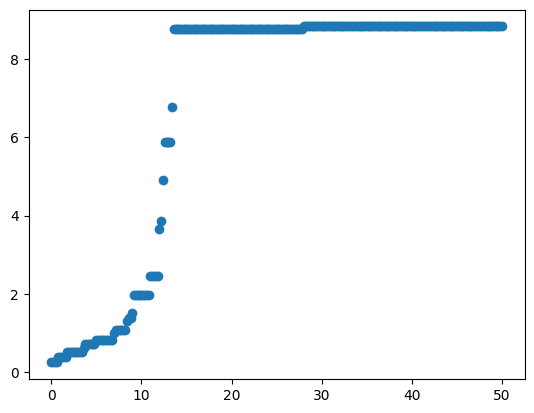

In [19]:
R0 = 1
dt = 0.2
K = 1e7
N_inf = 15**3
St_inf = 0.25

perc = []
numbers = []
volumes = []
volume_perc = []
max_st = []
vol_density = []
possible_st = []
eta_1_list = [] 
eta_2_list = []
eta_3_list = []

perc_b = []
numbers_b = []
volumes_b = []
volume_perc_b = []
max_st_b = []
vol_density_b = []
possible_st_b = []


for f, file in enumerate(files):
    data = np.load(os.path.join(directory, file))
    data = data[:, 1:]
    inside, outside = find_inside_points(data)
    inside_stokes = inside[:, -1]
    outside_stokes = outside[:, -1]
    eta_1 = (48/np.pi) * (np.sum(inside_stokes**1.5) / (N_inf * (St_inf**1.5)))
    eta_2 = (3/np.pi) * (len(inside_stokes) / N_inf)
    eta_3 = np.sum(inside_stokes**1.5) / np.sum(outside_stokes**1.5)
    eta_1_list.append(eta_1)
    eta_2_list.append(eta_2)
    eta_3_list.append(eta_3)
    max_st.append(np.max(inside_stokes) if len(inside_stokes) > 0 else None)

# plt.plot(np.arange(len(eta_1_list)) * dt, eta_1_list)
# plt.plot(np.arange(len(eta_2_list)) * dt, eta_2_list)
# plt.plot(np.arange(len(eta_3_list)) * dt, eta_3_list)
plt.plot(np.arange(len(max_st)) * dt, max_st, 'o') 

# for f, file in enumerate(files_b):
#     data = np.load(os.path.join(directory_b, file))
#     inside = data[:, 1] ** 2 + data[:, 2] ** 2 < R0
#     inside_stokes = data[inside, -1]
#     inside_volume = np.sum(inside_stokes ** 1.5)
#     perc_b.append(np.sum(inside) / len(inside))
#     numbers_b.append(np.sum(inside))
#     volumes_b.append(inside_volume)
#     volume_perc_b.append(inside_volume / np.sum(data[:, -1] ** 1.5))
#     max_st_b.append(np.max(inside_stokes) if len(inside_stokes) > 0 else None)
#     vol_density_b.append(np.sum((inside_stokes / K) ** 1.5) / (R0**3))




# fig, ax = plt.subplots(3, 2, figsize=(15, 12))
# ax[0,1].plot(np.arange(len(perc)) * dt, perc, '--', label='0', markersize=1)
# # ax[0,1].plot(np.arange(len(perc_b)) * dt, perc_b, '--', label='0', markersize=1)
# ax[0,1].set_title('percentage of particles inside')
# ax[0,1].set_xlabel('tau_f')
# ax[0,0].plot(np.arange(len(numbers))* dt, numbers/numbers[0], '--', label='no bounce',markersize=1)
# # ax[0,0].plot(np.arange(len(numbers_b))* dt, numbers_b/numbers_b[0], '--', label='bounce',markersize=1)
# ax[0,0].set_title('number of particles inside')
# ax[0,0].legend(['no bounce', 'bounce'])
# ax[1,0].plot(np.arange(len(volumes))* dt, volumes/volumes[0], '--', label='0', markersize=1)
# # ax[1,0].plot(np.arange(len(volumes_b))* dt, volumes_b/volumes_b[0], '--', label='0', markersize=1)
# ax[1,0].set_title('Volume of particles inside')
# ax[1,1].plot(np.arange(len(volume_perc))* dt, volume_perc, '--', label='0',markersize=1)
# # ax[1,1].plot(np.arange(len(volume_perc_b))* dt, volume_perc_b, '--', label='0',markersize=1)
# ax[1,1].set_title('Volume percentage of particles inside')
# ax[2,0].plot(np.arange(len(max_st))* dt, max_st, 'o', label='0', markersize=1)
# # ax[2,0].plot(np.arange(len(max_st_b))* dt, max_st_b, 'o', label='0', markersize=1)
# ax[2,0].set_title('Max Stokes inside')
# ax[2,1].plot(np.arange(len(vol_density))* dt, vol_density, 'o', label='0', markersize=1)
# # ax[2,1].plot(np.arange(len(vol_density_b))* dt, vol_density_b, 'o', label='0', markersize=1)

# plt.show()


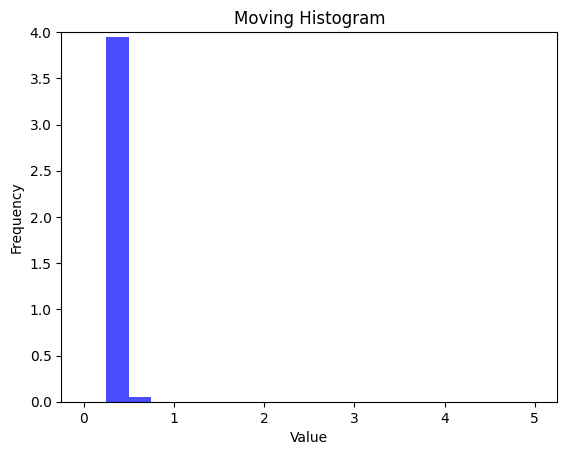

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots()
x_data = []

# Set the desired x-axis range
x_min = 0
x_max = 5
ax.set_xlim(x_min, x_max)

# Function to update the histogram
def update(frame):
    # Generate some random data for each frame
    data = np.load(os.path.join(directory, files[frame]))
    inside = data[:, 1] ** 2 + data[:, 2] ** 2 < R0
    stokes = data[inside, -1]
    x_data.append(stokes)
    
    # Update the histogram with the new data
    ax.clear()
    ax.hist(stokes, bins=20, color='blue', alpha=0.7, range=(x_min, x_max), density=True)
    ax.set_ylim(0, 4)
    ax.set_title('Moving Histogram')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Create the animation
ani = FuncAnimation(fig, update, frames=range(len(files)), repeat=False)

# Save the animation as a GIF
ani.save('moving_histogram.mp4', writer='ffmpeg', dpi=300)

# plt.show()  # optional, this line can be removed if you don't want to display the animation


[]

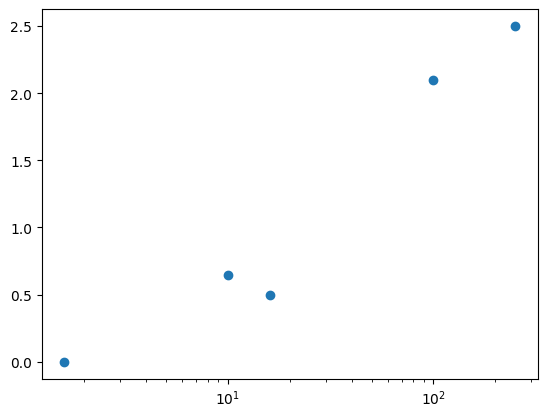

In [29]:
st0 = np.array([0.25, 0.25, 0.01, 2.5, 0.25, 2.5, 2.5, 0.1])
fr = np.array([5, 2, 5, 5, 10, 10, 2, 5])
param = fr**2 / st0
vol_change = np.array([2.1, 0.5, None, 0.65, None, None, 0, 2.5])
type = ['increase', 'decrease', 'no plateau', 'decrease', 'no plateau', 'no plateau', 'decrease', 'increase']
plt.plot(param, vol_change, 'o')
plt.semilogx()

[]

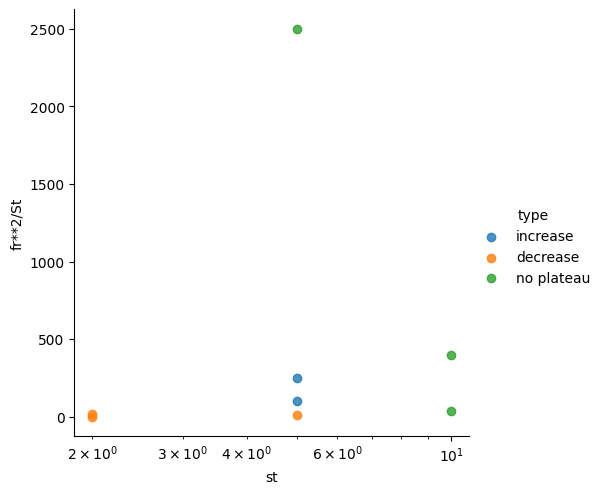

In [34]:
import seaborn as sns
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'st': fr,
    'fr**2/St': param,
    'type': type
})

# Create a scatter plot with a linear fit
sns.lmplot(x='st', y='fr**2/St', hue='type', data=df, fit_reg=False, logx=True)
plt.semilogx()